In [9]:
import numpy as np
import cvxpy as cp
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy.special import expit, logit
from joblib import Parallel, delayed
from tqdm.auto import tqdm
import multiprocessing as mp
from threading import Thread
from math import erf
from scipy import optimize
from sklearn.isotonic import IsotonicRegression
from scipy.stats import beta



In [16]:
class OptimisticBandit:
    def __init__(self, products, prices, budget, T):
        self.products = products
        self.prices = prices
        self.rem_budget = budget
        self.T = T
        self.t = 1
        self.n_r = defaultdict(int)
        self.n_c = defaultdict(int)
        self.sum_r = defaultdict(float)
        self.sum_c = defaultdict(float)
        self.init_r_ucb = (1 + np.sqrt(2 * np.log(T) / 1))*2
        self.rho_t = budget/T
        self.rhos = [self.rho_t]
        self.lr = 0.1
        self.hg = 5

        self.r_ucbs = []
        self.c_ucbs = []

    def conf_width(self, n):
        n = np.where(n>0., n, 1.0)
        return np.sqrt((2 * np.log(self.T)) / n)

    def plot_rhos(self):
        plt.figure(figsize=(15, 8))
        plt.plot(np.arange(len(self.rhos)-500), self.rhos[:len(self.rhos)-500])
        initial_value = self.rhos[0]
        plt.axline((0, initial_value), (1, initial_value), linewidth=4, color='r')
        plt.title("Agent's learnt rhos")
        plt.show()

    def _ensure_atom_cache(self):
        """Precompute and cache atom indexing for vectorized optimization."""
        if getattr(self, "_atom_cache_ready", False):
            return

        # Flatten all (product, price) atoms
        atoms = [(p, pr) for p in self.products for pr in self.prices[p]]
        self._atoms = atoms
        self._n_atoms = len(atoms)
        # Arrays for products and prices aligned with atom index
        self._atom_products = np.array([p for p, pr in atoms], dtype=object)
        self._atom_prices   = np.array([pr for p, pr in atoms], dtype=float)

        # Indices per product
        self._idxs_by_product = {
            p: np.where(self._atom_products == p)[0] for p in self.products
        }

        self._atom_cache_ready = True


    @staticmethod
    def isotonic_survival(prices_sorted, n_counts, s_successes):
        # prices_sorted: (m,) increasing; n_counts, s_successes aligned
        # raw rates only where n>0
        rate = np.divide(s_successes, np.maximum(n_counts, 1), out=np.zeros_like(s_successes, dtype=float), where=n_counts>0)
        iso = IsotonicRegression(increasing=False, out_of_bounds="clip")
        S_hat = iso.fit_transform(prices_sorted, rate, sample_weight=n_counts)
        F_hat = 1.0 - S_hat
        return S_hat, F_hat

    def _isotonic_bounds_for_product(self, prices, n_counts, s_successes,
                                 level=0.95, prior_strength=2.0,
                                 prior_high=1.0, prior_low=0.0, prior_shape=1.0):
        """
        Returns monotone-decreasing S_hat,S_lcb,S_ucb on the given price grid.
        `prior_strength` is total pseudo-counts per price (>0).
        Prior mean profile goes from prior_high at the lowest price to prior_low at the highest,
        with curvature controlled by prior_shape (1.0 linear; >1 convex; <1 concave).
        """
        prices = np.asarray(prices, dtype=float)
        n = np.asarray(n_counts, dtype=int)
        s = np.asarray(s_successes, dtype=int)
        m = len(prices)

        # ---- Monotone prior over sale prob S(p): high at low price, low at high price
        r = np.linspace(0.0, 1.0, m) ** prior_shape                # 0 at low price, 1 at high
        m0 = prior_high * (1.0 - r) + prior_low * r                # prior mean per price
        a0 = prior_strength * m0                                   # pseudo-successes
        b0 = prior_strength * (1.0 - m0)                           # pseudo-failures

        s_aug = s + a0
        n_aug = n + a0 + b0

        rate = (s_aug + 1.0) / (n_aug + 1.0)
        w    = n_aug


        # ---- Isotonic (decreasing) fit for S(p)
        iso = IsotonicRegression(increasing=False, out_of_bounds="clip")
        S_hat = iso.fit_transform(prices, rate, sample_weight=w)

        # ---- Blockwise Beta credible bands using posterior (data + prior)
        S_lcb = np.empty(m); S_ucb = np.empty(m)
        alpha = 1.0 - level
        start = 0
        for i in range(1, m + 1):
            if i == m or not np.isclose(S_hat[i], S_hat[i-1], atol=1e-12, rtol=0.0):
                # aggregate REAL data and PRIOR within this constant block
                n_blk = int(n[start:i].sum())
                s_blk = int(s[start:i].sum())
                a0_blk = float(a0[start:i].sum())
                b0_blk = float(b0[start:i].sum())
                a_post = s_blk + a0_blk + 0.5
                b_post = (n_blk - s_blk) + b0_blk + 0.5
                lo = float(beta.ppf(alpha/2.0, a_post, b_post))
                hi = float(beta.ppf(1.0 - alpha/2.0, a_post, b_post))
                S_lcb[start:i] = lo; S_ucb[start:i] = hi
                start = i

        # safety
        S_hat = np.clip(S_hat, 0.0, 1.0)
        S_lcb = np.minimum(np.maximum(S_lcb, 0.0), S_hat)
        S_ucb = np.maximum(np.minimum(S_ucb, 1.0), S_hat)
        return S_hat, S_lcb, S_ucb


    def play(self):
        self._ensure_atom_cache()

        # Pull stats into vectors aligned with atom order
        n_r   = np.array([self.n_r[a]   for a in self._atoms], dtype=float)   # times price was played
        n_c   = np.array([self.n_c[a]   for a in self._atoms], dtype=float)   # times price was played
        sum_c = np.array([self.sum_c[a] for a in self._atoms], dtype=float)   # sales at that price

        w_r = self.conf_width(n_c)

        # Arrays to fill (aligned with atoms)
        S_hat_all = np.zeros_like(sum_c, dtype=float)
        S_lcb_all = np.zeros_like(sum_c, dtype=float)
        S_ucb_all = np.zeros_like(sum_c, dtype=float)

        # Per-product isotonic fit + Jeffreys CIs on blocks
        for p, idxs in self._idxs_by_product.items():
            prices_p = np.asarray(self.prices[p], dtype=float)                       # (m,)
            n_p      = n_r[idxs].astype(int)
            s_p      = sum_c[idxs].astype(int)

            S_hat, S_lcb, S_ucb = self._isotonic_bounds_for_product(prices_p, n_p, s_p, level=0.5)
            S_hat_all[idxs] = S_hat
            S_lcb_all[idxs] = S_lcb
            S_ucb_all[idxs] = S_ucb

        # Use UCBs for conservative planning:
        # - Revenue UCB: price * UCB_S
        # - Consumption UCB (for budget constraint): UCB_S
        prices_all = self._atom_prices.astype(float)
        r_ucb = prices_all #+ w_r #* S_ucb_all
        c_ucb = np.clip(S_hat_all, 0., 1.)

        # (optional) keep LCBs if you want to log or add risk-aware objectives
        #r_lcb = prices_all * S_lcb_all
        #c_lcb = S_lcb_all

        self.r_ucbs.append(r_ucb)    # store if you want to inspect later
        self.c_ucbs.append(c_ucb)



        # Optimization (unchanged structure, but now use c_ucb)
        x = cp.Variable(self._n_atoms)
        if self.hg>0:
            #print(r_ucb)
            #print(c_ucb)
            self.hg-=1
        y = np.multiply(r_ucb, c_ucb) #+ w_r
        obj = cp.Maximize(y @ x)
        constraints = [
            c_ucb @ x <= self.rho_t,   # conservative budget/resource constraint
            x >= 0,
        ]
        for p, idxs in self._idxs_by_product.items():
            constraints.append(cp.sum(x[idxs]) == 1)

        xv = np.zeros(self._n_atoms)
        for _, idxs in self._idxs_by_product.items():
            xv[idxs[-1]] = 1.0

        try:
            prob = cp.Problem(obj, constraints)
            prob.solve(solver=cp.CLARABEL)
        except Exception as e:
            print(e)

        if x.value is not None:
            xv = np.asarray(x.value).ravel()
            xv = np.clip(xv, 0., 1.)

        action = {}
        for p, idxs in self._idxs_by_product.items():
            sum_x = np.sum(xv[idxs])
            # argmax over the product's slice
            normalized_p = xv[idxs]/sum_x
            k = np.random.choice(idxs, p=normalized_p)
            #k_rel = np.argmax(xv[idxs])
            #k = idxs[k_rel]
            action[p] = float(self._atom_prices[k])

        return action

    def plot_ucbs(self, extensive=False):
        R = np.asarray(self.r_ucbs)   # (t, A)
        C = np.asarray(self.c_ucbs)   # (t, A)
        t = np.arange(1, R.shape[0] + 1)
        if extensive:
            for k, (p, pr) in enumerate(self._atoms):
                fig, ax = plt.subplots(figsize=(7, 3))
                ax.plot(t, R[:, k], label="r_ucb")
                ax.plot(t, C[:, k], label="c_lcb")
                ax.set_title(f"{p} @ {pr:g}")
                ax.set_xlabel("time")
                ax.set_ylabel("value")
                ax.legend()
                ax.grid(alpha=0.3)
                plt.show()

        last_C = C[-1]  # (A,)
        for prod in self.products:
            idxs = self._idxs_by_product[prod]
            x = self._atom_prices[idxs]   # prices for this product
            y = last_C[idxs]              # last c_lcb for those arms

            order = np.argsort(x)
            x, y = x[order], y[order]

            fig, ax = plt.subplots(figsize=(7, 3))
            ax.plot(x, y, linewidth=1, alpha=0.7)
            ax.scatter(x, y)

            # annotate each point with its y value
            for xi, yi in zip(x, y):
                ax.annotate(f"{yi:.4f}", (xi, yi),
                            textcoords="offset points", xytext=(6, 6), ha="left")

            ax.set_title(f"Last c_lcb by price — {prod}")
            ax.set_xlabel("price")
            ax.set_ylabel("last c_lcb")
            ax.grid(alpha=0.3)
            plt.show()

        last_R = R[-1]  # (A,)
        for prod in self.products:
            idxs = self._idxs_by_product[prod]
            x = self._atom_prices[idxs]   # prices for this product
            y = last_R[idxs]              # last c_lcb for those arms

            order = np.argsort(x)
            x, y = x[order], y[order]

            fig, ax = plt.subplots(figsize=(7, 3))
            ax.plot(x, y, linewidth=1, alpha=0.7)
            ax.scatter(x, y)

            # annotate each point with its y value
            for xi, yi in zip(x, y):
                ax.annotate(f"{yi:.4f}", (xi, yi),
                            textcoords="offset points", xytext=(6, 6), ha="left")

            ax.set_title(f"Last r_lcb by price — {prod}")
            ax.set_xlabel("price")
            ax.set_ylabel("last r_lcb")
            ax.grid(alpha=0.3)
            plt.show()

    def update(self, outcomes):
        self.t += 1
        tot_sold = 0
        for (prod,price), (rew,sold) in outcomes.items():
            tot_sold += sold
            self.n_r[(prod,price)] += 1
            self.sum_r[(prod,price)] += rew
            self.sum_c[(prod, price)] += sold
            index = np.where(self.prices[prod] == price)[0][0]
            if sold==1:
                #index = index+5 if index < len(self.prices[self.products[0]])-5 else index
                for p in self.prices[prod][:index+1]:
                    self.n_c[(prod, p)] += 1
                    #self.sum_c[(prod, p)] += 1
            else:
                #index = index-5 if index >= 5 else index
                for p in self.prices[prod][index:]:
                    self.n_c[(prod, p)] += 1

        self.rem_budget -= tot_sold
        self.rho_t = self.rho_t + self.lr*(self.rhos[0]-tot_sold)
        self.rhos.append(self.rho_t)

### Environment

In [11]:
class MultiProductPricingEnvironment:
    def __init__(self, products,
                 means,
                 covs,
                 seed=42,
                 plot_distribution=True,
                 T=None):
        self.products = products
        self.d = len(products)
        self.means, self.covs = self.delta_method_latent_from_logitnormal(means, covs)
        self.rng = np.random.default_rng(seed)
        self.cached_valuations = False

        if plot_distribution:
            n_samples = 100_000
            bins=100
            samples = self.sample_valuations(n_samples)
            for i, product in enumerate(products):

                plt.figure(figsize=(7, 3))
                plt.hist(samples[:, i], bins=bins, density=True, stacked=True)
                plt.title(f"Distribution of valuations for product {product} (100000 rounds)")
                plt.xlabel("valuation")
                plt.ylabel("density")
                plt.xlim(0, 1)
                plt.tight_layout()
                plt.show()

        if T is not None:
            self.valuations_samples = self.sample_valuations(T)
            self.cached_valuations = True
            self.i=0

    def compute_Q(self, prices_grid, eps = 1e-12):

        dvs = np.sqrt(np.clip(np.diag(self.covs), 0.0, None))

        pc = np.clip(prices_grid, eps, 1 - eps)
        logits = np.log(pc / (1 - pc))

        Phi = lambda x: 0.5 * (1.0 + np.vectorize(erf)(x / np.sqrt(2.0)))
        z = (logits[None, :] - self.means[:, None]) / np.where(dvs > 0, dvs, 1.0)[:, None]
        Q = 1.0 - Phi(z)

        Q[:, prices_grid <= 0.0] = 1.0
        Q[:, prices_grid >= 1.0] = 0.0

        # If there are determinist prices (zero variance), set the prices above the valuation to 0 and 1 below
        det = dvs == 0.0
        if np.any(det):
            v = 1.0 / (1.0 + np.exp(-self.means[det]))
            Q[det] = (v[:, None] >= prices_grid[None, :]).astype(float)
        return Q



    @staticmethod
    def delta_method_latent_from_logitnormal(m, C):
        """
        Approximate latent Gaussian parameters (mu, Sigma_Z) for a multivariate logit-normal
        with desired mean vector m in (0,1)^d and covariance C.

        Uses first-order delta method:
            J = diag( m_i * (1 - m_i) )
            Sigma_Z ≈ J^{-1} C J^{-1}
            mu ≈ logit(m)
        """
        m = np.asarray(m, dtype=float)
        C = np.asarray(C, dtype=float)
        if m.ndim != 1:
            raise ValueError("m must be a 1-D array of means in (0,1).")
        if C.shape != (m.size, m.size):
            raise ValueError("C must be a square matrix with same dimension as m.")
        if np.any((m <= 0) | (m >= 1)):
            raise ValueError("All entries of m must lie strictly in (0,1).")

        mu = logit(m)
        gprime = m * (1.0 - m)  # derivative of expit at mu where expit(mu)=m
        if np.any(gprime <= 0):
            raise ValueError("Means too close to 0 or 1 make the delta method unstable.")
        Jinv = np.diag(1.0 / gprime)
        Sigma_Z = Jinv @ C @ Jinv
        # Symmetrize small numerical asymmetry
        Sigma_Z = 0.5 * (Sigma_Z + Sigma_Z.T)
        return mu, Sigma_Z

    def sample_valuations(self, n=1):
        if self.cached_valuations:
            self.i+=1
            return self.valuations_samples[self.i-1]
        z = self.rng.multivariate_normal(self.means, self.covs, size=n)
        if n==1:
            return expit(z).ravel()
        return expit(z)

    def round(self, chosen_prices):
        chosen_prices_arr = np.array([chosen_prices[p] for p in self.products], dtype=float)
        vals = self.sample_valuations()
        sold = (vals >= chosen_prices_arr).astype(int)
        reward = np.multiply(chosen_prices_arr, sold)
        return sold, reward


### Clairvoyant

In [12]:
def compute_clairvoyant_multi(price_grid, q_matrix, rho, rng=None):
    """
    price_grid : shape (K,)
    q_matrix   : shape (N, K)  -> buy probabilities q_i(p_j)
    rho        : expected-units pace for the round

    Returns:
      x_opt : shape (N, K) (continuous mix; will be normalized per product)
      obj   : optimal expected profit per round
      used_units : sum q_i(p_j) * x_opt[i,j]
      action : dict {product_index -> chosen price} (sampling proportional to x_opt per product)
    """
    N, K = q_matrix.shape
    P = np.asarray(price_grid, dtype=float)
    V = q_matrix * P[None, :]              # expected profit per (i,j)
    r = V.reshape(-1)                      # objective coefficients
    c = q_matrix.reshape(-1)               # units coefficients
    n_atoms = N * K

    # CVXPY decision variable (continuous 0–1, enforced by equality + nonnegativity)
    x = cp.Variable(n_atoms)

    # Objective and constraints (vectorized)
    obj = cp.Maximize(r @ x)
    constraints = [
        c @ x <= float(rho),   # budget/resource (pace) constraint
        x >= 0,
        # x <= 1  # not needed because per-product sum == 1 and x >= 0
    ]

    # Each product: sum over its K prices equals 1 (mirrors your agent’s loop)
    for i in range(N):
        idxs = slice(i * K, (i + 1) * K)
        constraints.append(cp.sum(x[idxs]) == 1)

    prob = cp.Problem(obj, constraints)

    # Solve (CLARABEL first, fallback to ECOS)
    #try:
    #prob.solve(solver=cp.GLPK_MI)
    prob.solve(solver=cp.CLARABEL)

    #except Exception:
    #    prob.solve(solver=cp.ECOS, warm_start=True)

    xv = np.asarray(x.value).ravel() if x.value is not None else np.zeros(n_atoms)
    xv = np.clip(xv, 0.0, 1.0)
    X = xv.reshape(N, K)

    obj_val = float(prob.value) if prob.value is not None else 0.0
    used_units = float(np.sum(q_matrix * X))

    # Build action exactly like your agent: sample within each product slice
    if rng is None:
        rng = np.random.default_rng()
    action = {}
    for i in range(N):
        slice_vals = X[i, :]
        s = slice_vals.sum()
        if s <= 0:
            # fallback: pick the price with max expected profit for this product
            j = int(np.argmax(V[i, :]))
        else:
            p = slice_vals / s
            j = int(rng.choice(np.arange(K), p=p))
        action[i] = float(P[j])

    return X, obj_val, used_units


In [13]:
def compute_clairvoyant_multi2(price_grid, q_matrix, rho, per_product_one_price=True):
    """
    price_grid : shape (K,)
    q_matrix   : shape (N, K)  -> buy probabilities q_i(p_j)
    rho        : expected-units pace for the round
    per_product_one_price : if True, enforce sum_j x_{i,j} <= 1 for each product i

    Returns:
      x_opt : shape (N, K) optimal mixture over (product, price) arms
      obj   : optimal expected profit per round
      used_units : sum q_i(p_j) * x_opt[i,j]
    """
    N, K = q_matrix.shape
    P = np.asarray(price_grid, dtype=float)
    V = q_matrix * P[None, :]  # zero costs => expected profit per arm

    # Flatten variables: x[i,j] -> x_flat[idx]
    def idx(i, j): return i * K + j
    nvar = N * K

    # Objective: maximize sum V*x  => minimize -V*x
    c = -V.reshape(-1)

    # Constraints
    A_ub = []
    b_ub = []

    # (i) Expected units: sum q*x <= rho
    A_units = q_matrix.reshape(-1)
    A_ub.append(A_units)
    b_ub.append(rho)

    # (ii) At most one price per product: sum_j x_{i,j} <= 1
    if per_product_one_price:
        for i in range(N):
            row = np.zeros(nvar)
            row[i*K:(i+1)*K] = 1.0
            A_ub.append(row)
            b_ub.append(1.0)

    # Bounds: 0 <= x <= 1
    bounds = [(0.0, 1.0)] * nvar

    res = optimize.linprog(
        c, A_ub=np.array(A_ub), b_ub=np.array(b_ub),
        bounds=bounds, method="highs"
    )
    x_flat = res.x
    x = x_flat.reshape(N, K)
    obj = -res.fun
    used_units = float(np.sum(q_matrix * x))
    return x, obj, used_units


### Parallelization helper functions

In [18]:

def _progress_listener(q, n_trials, leave=False):
    """
    Render one tqdm bar per trial in the main process.
    Workers send ('init', trial_idx, total), ('update', trial_idx, n), ('close', trial_idx, 0).
    """
    bars = {}
    closed = set()
    while len(closed) < n_trials:
        msg = q.get()
        if msg is None:  # termination signal
            break
        kind, trial_idx, val = msg
        if kind == 'init':
            # Create the bar for this trial if not exists
            if trial_idx not in bars:
                bars[trial_idx] = tqdm(total=int(val),
                                       desc=f"Trial {trial_idx+1}",
                                       position=trial_idx,
                                       leave=leave)
        elif kind == 'update':
            if trial_idx in bars:
                bars[trial_idx].update(int(val))
        elif kind == 'close':
            if trial_idx in bars and trial_idx not in closed:
                bars[trial_idx].close()
                closed.add(trial_idx)

    # Ensure all bars are closed
    for tid, bar in bars.items():
        if tid not in closed:
            bar.close()

def _start_progress(n_trials, leave=False):
    mgr = mp.Manager()
    q = mgr.Queue()
    th = Thread(target=_progress_listener, args=(q, n_trials, leave), daemon=True)
    th.start()
    return q, th, mgr

# ----------------------------------------
# One trial (runs in a worker process)

def run_all_trials_parallel(seeds, products, prices, budget, T, means, covs, n_jobs=-1, leave=False):
    progress_q, progress_thread, mgr = _start_progress(len(seeds), leave=leave)
    try:
        results = Parallel(n_jobs=n_jobs, prefer="processes")(
            delayed(run_single_trial)(
                trial_idx, products, prices, budget, T, means, covs, seed, progress_q
            )
            for trial_idx, seed in enumerate(seeds)
        )
    finally:
        # tell listener to exit if not already
        progress_q.put(None)
        progress_thread.join()
        mgr.shutdown()

    all_regrets = [results[i][0] for i in range(len(results))]
    actions = [results[i][1] for i in range(len(results))]
    return all_regrets, actions


def run_single_trial(trial_idx, products, prices, budget, T, means, covs, seed=42, progress_q=None):

    if progress_q is not None:
        progress_q.put(('init', trial_idx, T))

    env = MultiProductPricingEnvironment(products=products, means=means, covs=covs, seed=seed, T=T, plot_distribution=False)
    agent = OptimisticBandit(products, prices, budget, T)
    Q = env.compute_Q(prices_per_product)
    boh, expected_clairvoyant_utility, floh = compute_clairvoyant_multi(prices_per_product, Q, budget/T)


    for row in Q:
        fig, ax = plt.subplots(figsize=(7, 3))
        y = row
        x = prices_per_product

        ax.plot(x, y, linewidth=1, alpha=0.7)
        ax.scatter(x, y)


        for xi, yi in zip(x, y):
            ax.annotate(f"{yi:.4f}", (xi, yi),
                        textcoords="offset points", xytext=(6, 6), ha="left")


        ax.set_title(f"Clairvoyant c_lcb")
        ax.set_xlabel("price")
        ax.set_ylabel("c_lcb")
        ax.grid(alpha=0.3)
        plt.show()

    cumulative_regret = []
    cum_reg = 0.0
    actions = []
    rhos = []

    rem_bud = budget

    for t in range(1, T + 1):
        if agent.rem_budget <= 0:
            # close early if budget exhausted
            if progress_q is not None:
                progress_q.put(('close', trial_idx, 0))
            break

        #print(agent.c_ucbs)
        action = agent.play()
        sold, reward = env.round(action)
        #print(np.sum(sold))

        rem_bud -= np.sum(sold)
        rho = rem_bud/(T-t+1)
        rhos.append(rho)

        outcomes = {(p, action[p]): (reward[i], sold[i]) for i, p in enumerate(products)}
        agent.update(outcomes)
        """
        _, exp_oracle_reward = oracle_action(products, prices, env, rho_t)
        cum_reg += exp_oracle_reward - reward
        cumulative_regret.append(cum_reg)
        """
        cum_reg += expected_clairvoyant_utility - reward.sum()
        cumulative_regret.append(cum_reg)
        actions.append(action)

        if progress_q is not None:
            progress_q.put(('update', trial_idx, 1))

    else:
        # loop ended normally
        if progress_q is not None:
            progress_q.put(('close', trial_idx, 0))

    #agent.plot_ucbs(extensive=False)
    #agent.plot_rhos()
    #plt.figure(figsize=(15, 8))
    #plt.plot(np.arange(len(rhos)-500), rhos[:len(rhos)-500])
    #plt.axline((0, 1), (1, 1), linewidth=4, color='r')
    #plt.title('Effective rhos')
    #plt.show()

    return cumulative_regret, actions


# Experiments

Discretizing prices with 14 values


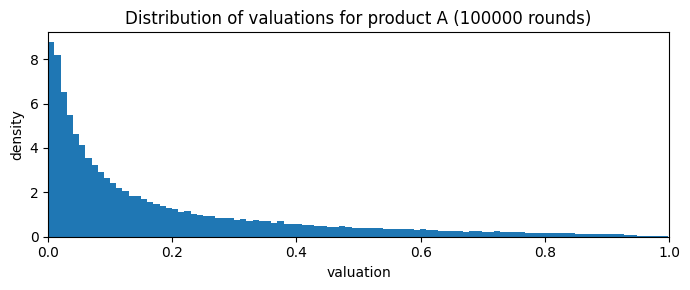

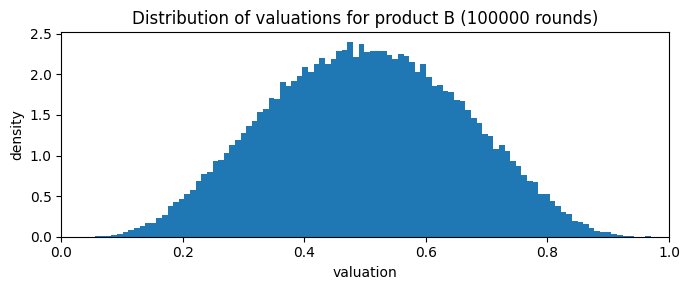

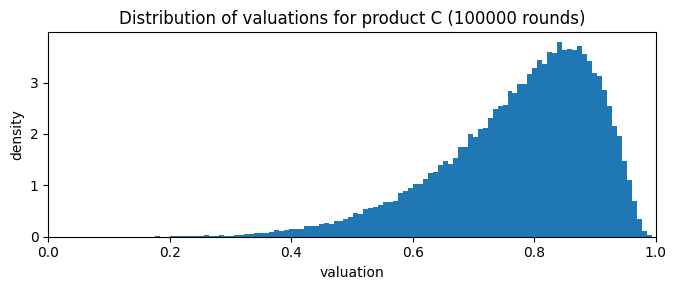

Trial 2:   0%|          | 0/3000 [00:00<?, ?it/s]

Trial 3:   0%|          | 0/3000 [00:00<?, ?it/s]

Trial 8:   0%|          | 0/3000 [00:00<?, ?it/s]

Trial 7:   0%|          | 0/3000 [00:00<?, ?it/s]

Trial 1:   0%|          | 0/3000 [00:00<?, ?it/s]

Trial 9:   0%|          | 0/3000 [00:00<?, ?it/s]

Trial 4:   0%|          | 0/3000 [00:00<?, ?it/s]

Trial 6:   0%|          | 0/3000 [00:00<?, ?it/s]

Trial 5:   0%|          | 0/3000 [00:00<?, ?it/s]

Trial 10:   0%|          | 0/3000 [00:00<?, ?it/s]

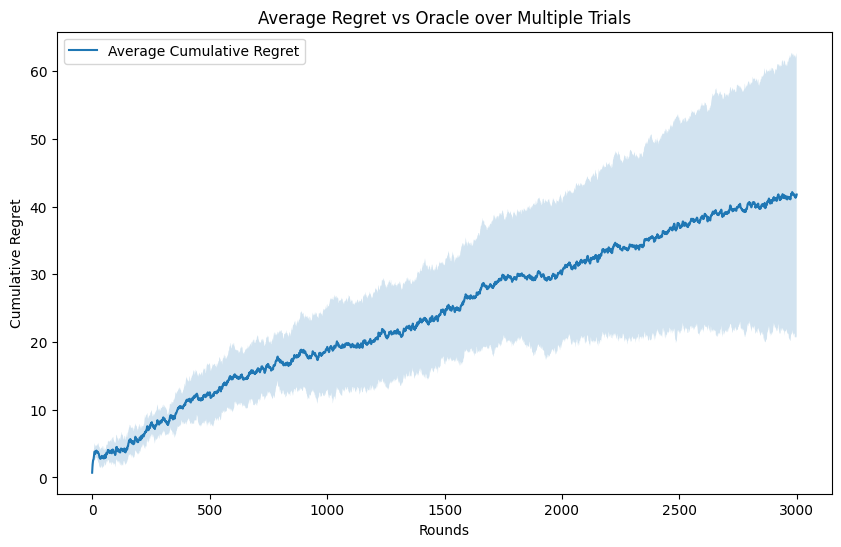

In [21]:

run_one = False
products = ['A','B','C']
budget = 3000
T = 3000
seeds = [23424,3431,65762,842357,2346532,13564,98765,2557,123564,123564]
epsilon = T ** (-0.33)
K = 1*int(1 / epsilon)
print(f'Discretizing prices with {K} values')
prices_per_product = np.linspace(0, 1, K)
prices = {'A': prices_per_product, 'B': prices_per_product, 'C': prices_per_product}
means = np.array([0.1, 0.5, 0.8])
covs = 0.005*np.array([[5., 0., 0.],
                         [0., 6., 0.],
                         [0., 0., 3.]])

# Just to plot distribution
env = MultiProductPricingEnvironment(products=products, means=means, covs=covs, plot_distribution=True)

if run_one:
    cum_regret, actions = run_single_trial(0, products, prices, budget, T, means, covs, seed=3)
    avg_regret = cum_regret
else:
    all_regrets, actions = run_all_trials_parallel(seeds, products, prices, budget, T, means, covs, n_jobs=-1)

    all_regrets = np.array([np.pad(r, (0, T-len(r)), 'edge') for r in all_regrets])
    avg_regret = all_regrets.mean(axis=0)
    regret_std = all_regrets.std(axis=0)

plt.figure(figsize=(10,6))
plt.plot(avg_regret, label='Average Cumulative Regret')
plt.fill_between(range(T), avg_regret-regret_std, avg_regret+regret_std, alpha=0.2)
plt.xlabel('Rounds')
plt.ylabel('Cumulative Regret')
plt.title('Average Regret vs Oracle over Multiple Trials')
plt.legend()
plt.show()

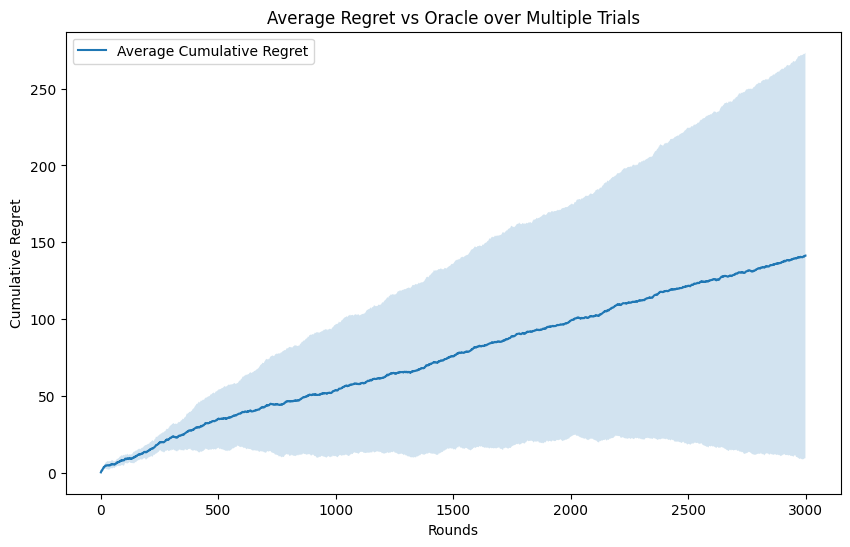

In [20]:
plt.figure(figsize=(10,6))
plt.plot(avg_regret, label='Average Cumulative Regret')
plt.fill_between(range(T), avg_regret-regret_std, avg_regret+regret_std, alpha=0.2)
plt.xlabel('Rounds')
plt.ylabel('Cumulative Regret')
plt.title('Average Regret vs Oracle over Multiple Trials')
plt.legend()
plt.show()

Discretizing prices with 85 values


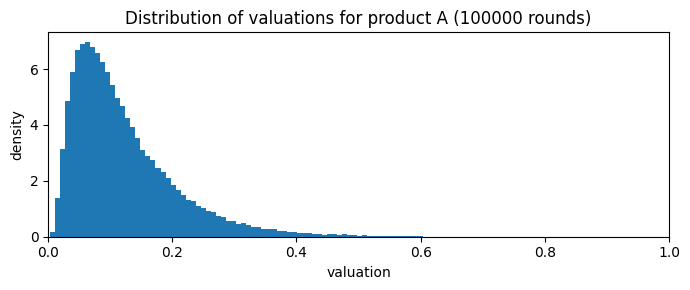

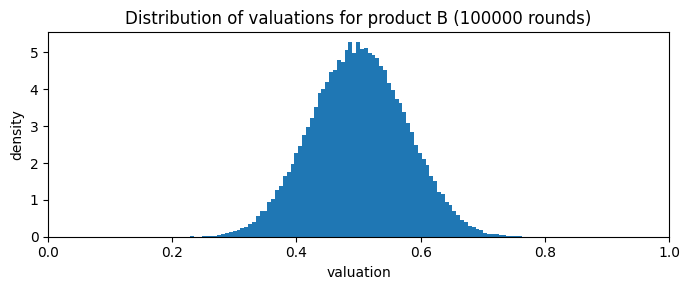

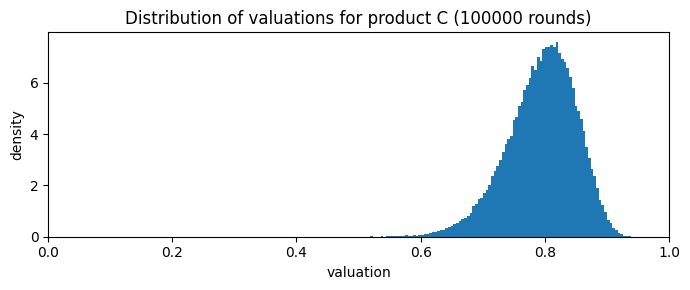

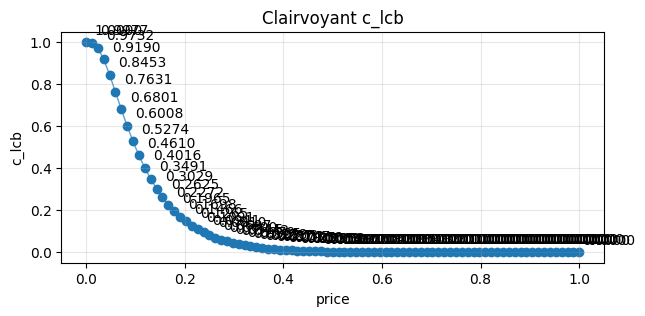

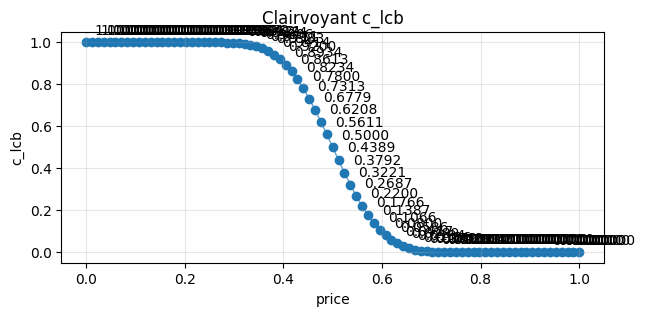

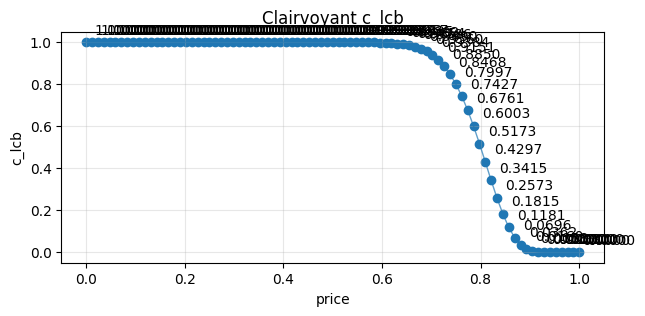

KeyboardInterrupt: 

In [12]:
# Only experiment run with argmax and not sampling

run_one = True
products = ['A','B','C']
budget = 3000
T = 6000
seeds = [23424,3431,65762,842357,2346532,13564,98765,2557,123564,123564]
epsilon = T ** (-0.33)
K = 5*int(1 / epsilon)
print(f'Discretizing prices with {K} values')
prices_per_product = np.linspace(0, 1, K)
prices = {'A': prices_per_product, 'B': prices_per_product, 'C': prices_per_product}
means = np.array([0.1, 0.5, 0.8])
covs = 0.001*np.array([[5., 0., 0.],
                         [0., 6., 0.],
                         [0., 0., 3.]])

# Just to plot distribution
env = MultiProductPricingEnvironment(products=products, means=means, covs=covs, plot_distribution=True)

if run_one:
    cum_regret, actions = run_single_trial(0, products, prices, budget, T, means, covs, seed=3)
    avg_regret = cum_regret
else:
    all_regrets, actions = run_all_trials_parallel(seeds, products, prices, budget, T, means, covs, n_jobs=-1)

    all_regrets = np.array([np.pad(r, (0, T-len(r)), 'edge') for r in all_regrets])
    avg_regret = all_regrets.mean(axis=0)
    regret_std = all_regrets.std(axis=0)

plt.figure(figsize=(10,6))
plt.plot(avg_regret, label='Average Cumulative Regret')
#plt.fill_between(range(T), avg_regret-regret_std, avg_regret+regret_std, alpha=0.2)
plt.xlabel('Rounds')
plt.ylabel('Cumulative Regret')
plt.title('Average Regret vs Oracle over Multiple Trials')
plt.legend()
plt.show()

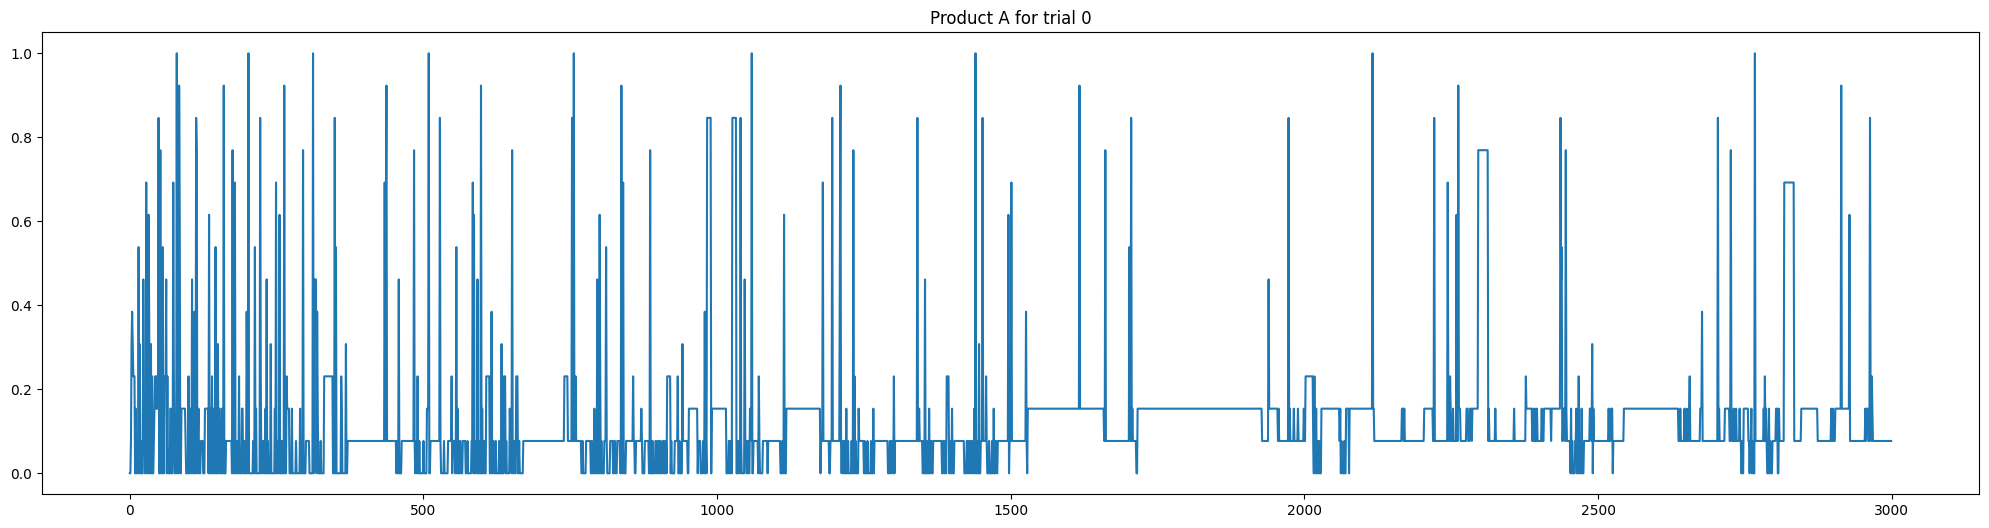

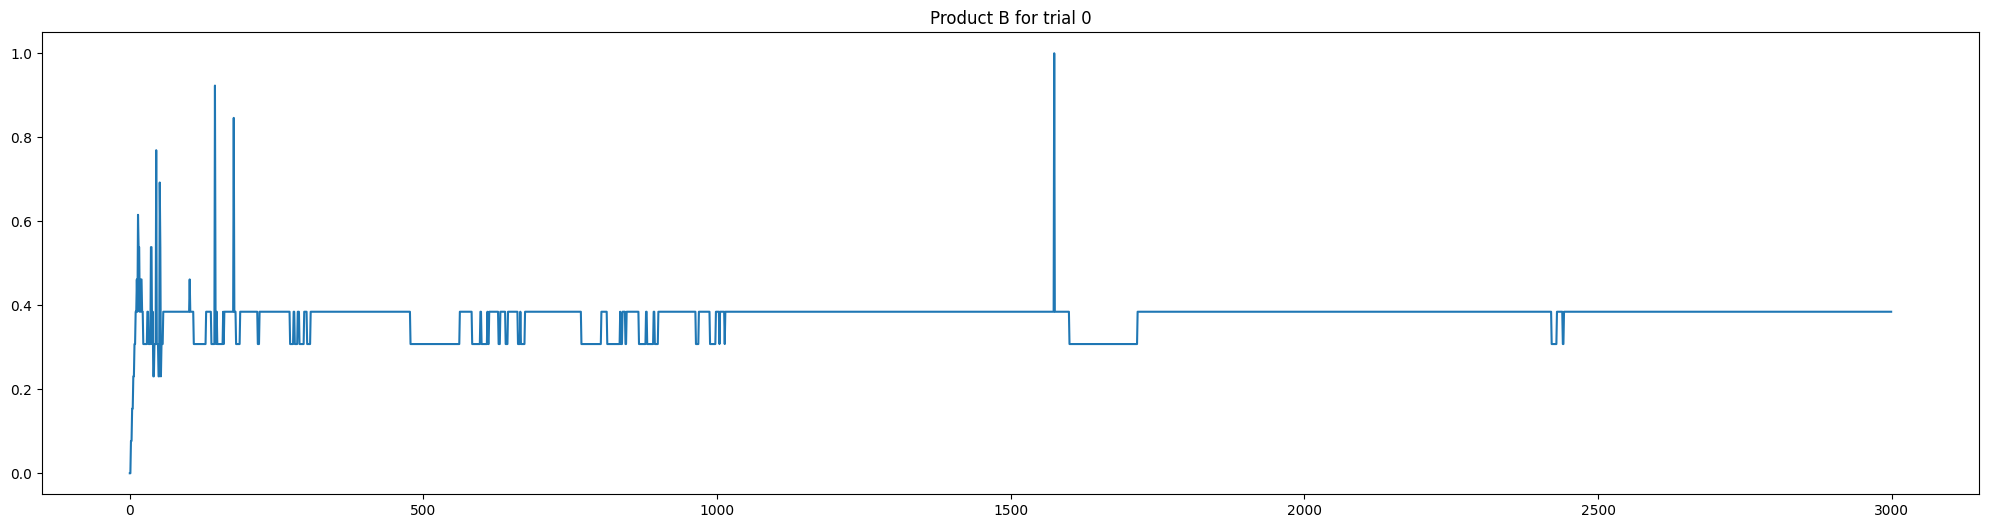

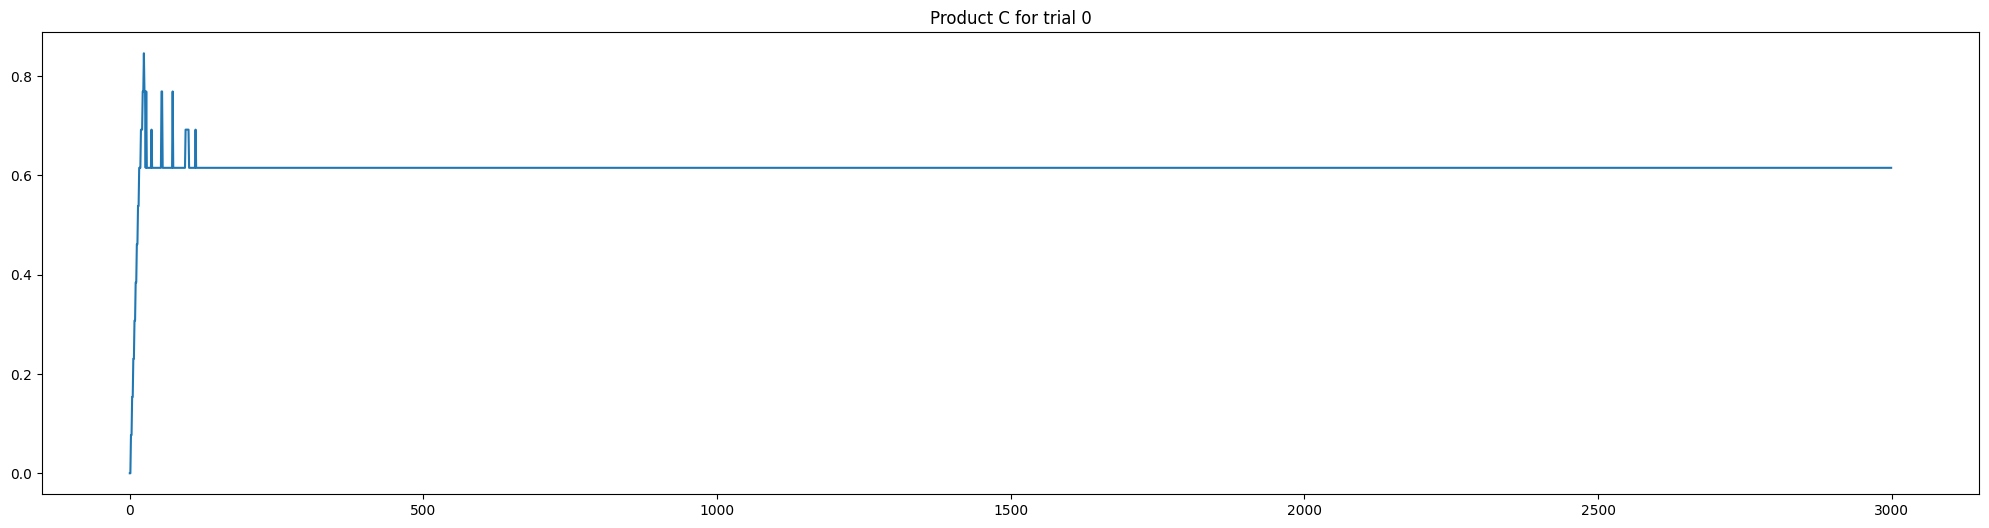

In [8]:
#actions_unpacked=[[list(d.values()) for d in group] for group in actions]
actions_unpacked=[[list(d.values()) for d in actions]]


for t, trial in enumerate(actions_unpacked[:2]):
    x = range(len(trial))
    for i, product in enumerate(products):
        y = [step[i] for step in trial]
        plt.figure(figsize=(25,6))
        plt.plot(x, y)
        plt.title(f'Product {product} for trial {t}')
        plt.show()


Discretizing prices with 17 values


Trial 1:   0%|          | 0/6000 [00:00<?, ?it/s]

Trial 2:   0%|          | 0/6000 [00:00<?, ?it/s]

Trial 3:   0%|          | 0/6000 [00:00<?, ?it/s]

Trial 4:   0%|          | 0/6000 [00:00<?, ?it/s]

Trial 5:   0%|          | 0/6000 [00:00<?, ?it/s]

Trial 6:   0%|          | 0/6000 [00:00<?, ?it/s]

Trial 7:   0%|          | 0/6000 [00:00<?, ?it/s]

Trial 8:   0%|          | 0/6000 [00:00<?, ?it/s]

Trial 9:   0%|          | 0/6000 [00:00<?, ?it/s]

Trial 10:   0%|          | 0/6000 [00:00<?, ?it/s]

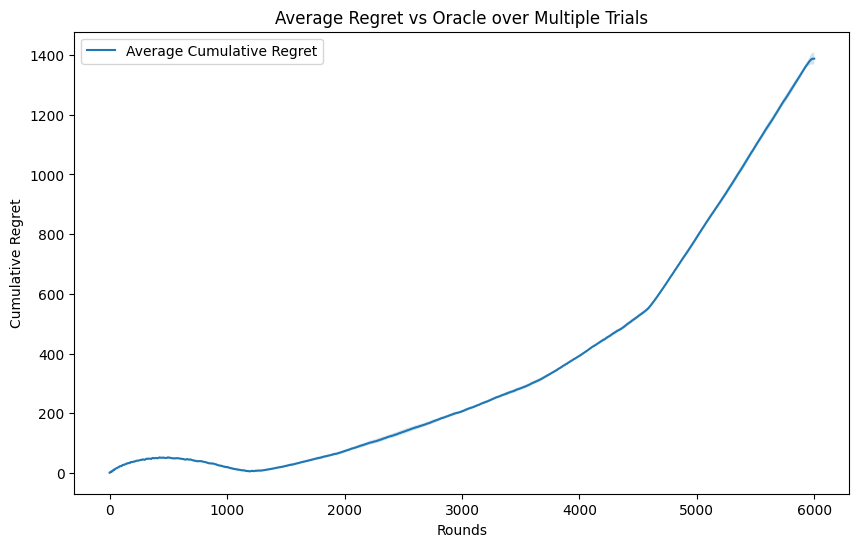

In [76]:
# Now with sampling

products = ['A','B','C']
budget = 6000
T = 6000
seeds = [23424,3431,65762,842357,2346532,13564,98765,2557,123564,123564]
epsilon = T ** (-0.33)
K = int(1 / epsilon)
print(f'Discretizing prices with {K} values')
prices_per_product = np.linspace(0, 1, K)
prices = {'A': prices_per_product, 'B': prices_per_product, 'C': prices_per_product}
means = np.array([0.1, 0.5, 0.8])
covs = 0.001*np.array([[1., 0., 0.],
                         [0., 2., 0.],
                         [0., 0., 0.5]])

# Just to plot distribution
#env = MultiProductPricingEnvironment(products=products, means=means, covs=covs, plot_distribution=True)

#run_single_trial(0, products, prices, budget, T, means, covs, seed=3)
all_regrets, actions = run_all_trials_parallel(seeds, products, prices, budget, T, means, covs, n_jobs=-1)

all_regrets = np.array([np.pad(r, (0, T-len(r)), 'edge') for r in all_regrets])
avg_regret = all_regrets.mean(axis=0)
regret_std = all_regrets.std(axis=0)

plt.figure(figsize=(10,6))
plt.plot(avg_regret, label='Average Cumulative Regret')
plt.fill_between(range(T), avg_regret-regret_std, avg_regret+regret_std, alpha=0.2)
plt.xlabel('Rounds')
plt.ylabel('Cumulative Regret')
plt.title('Average Regret vs Oracle over Multiple Trials')
plt.legend()
plt.show()

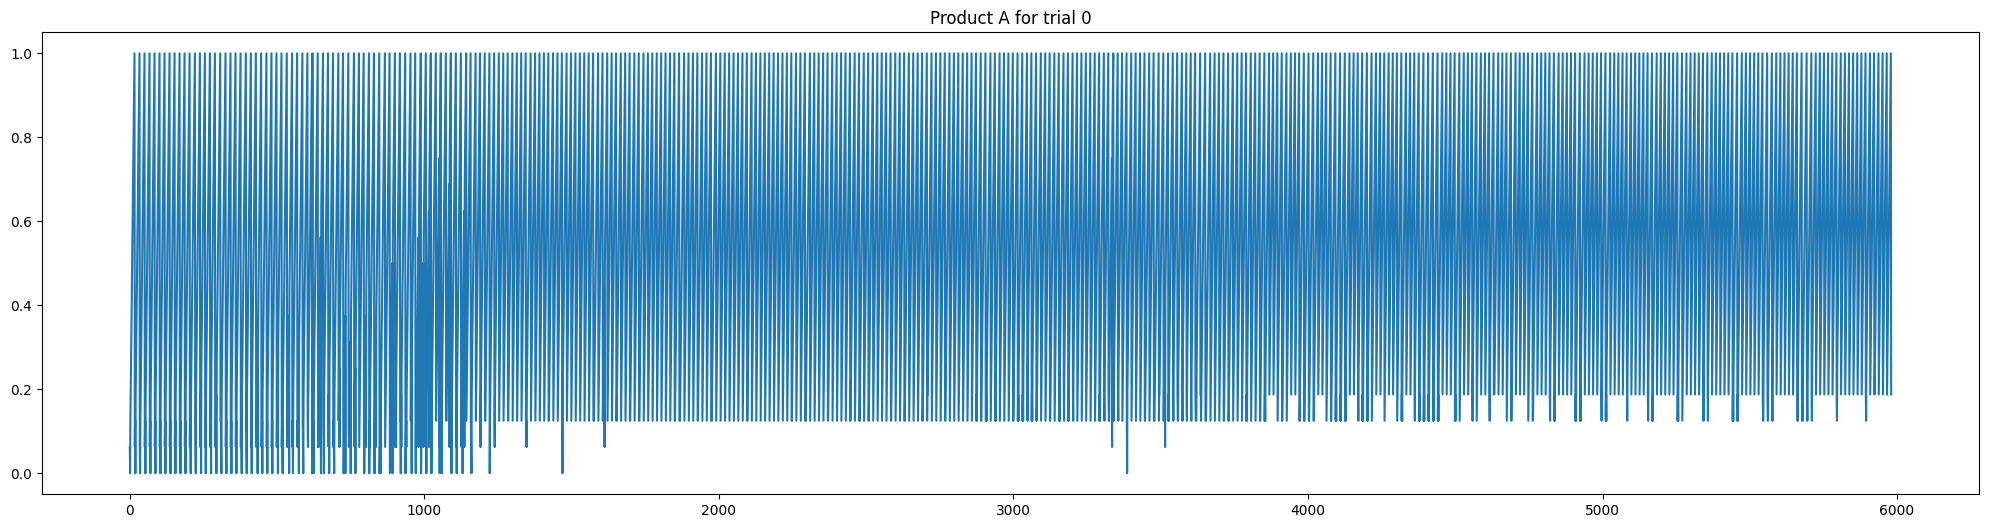

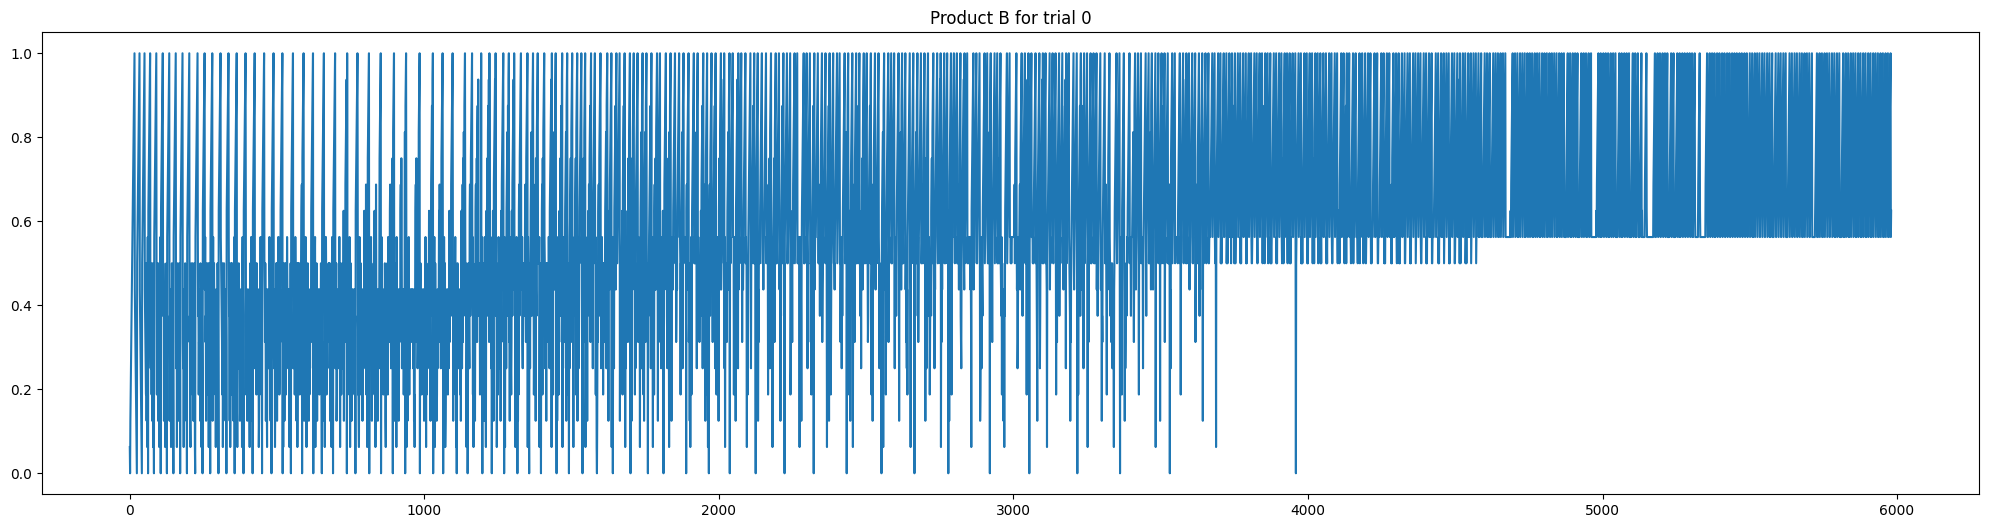

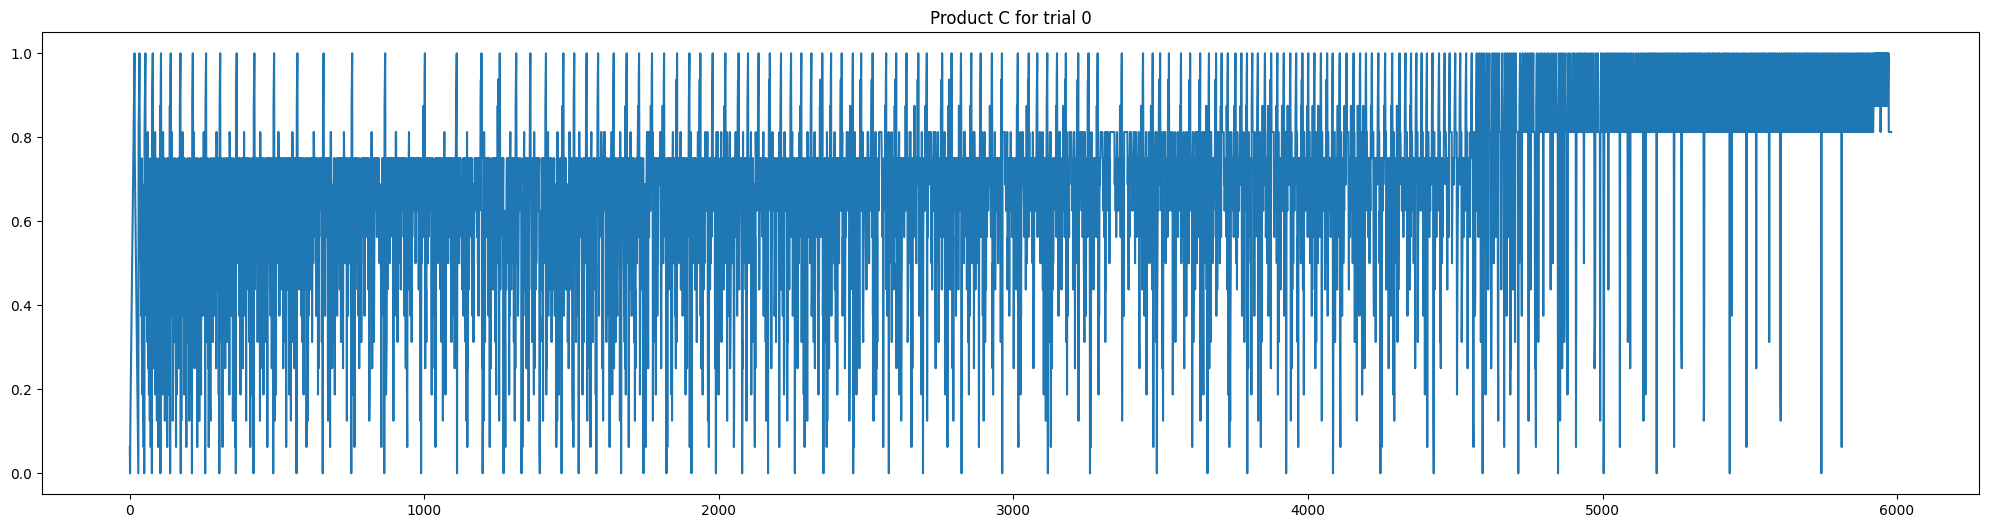

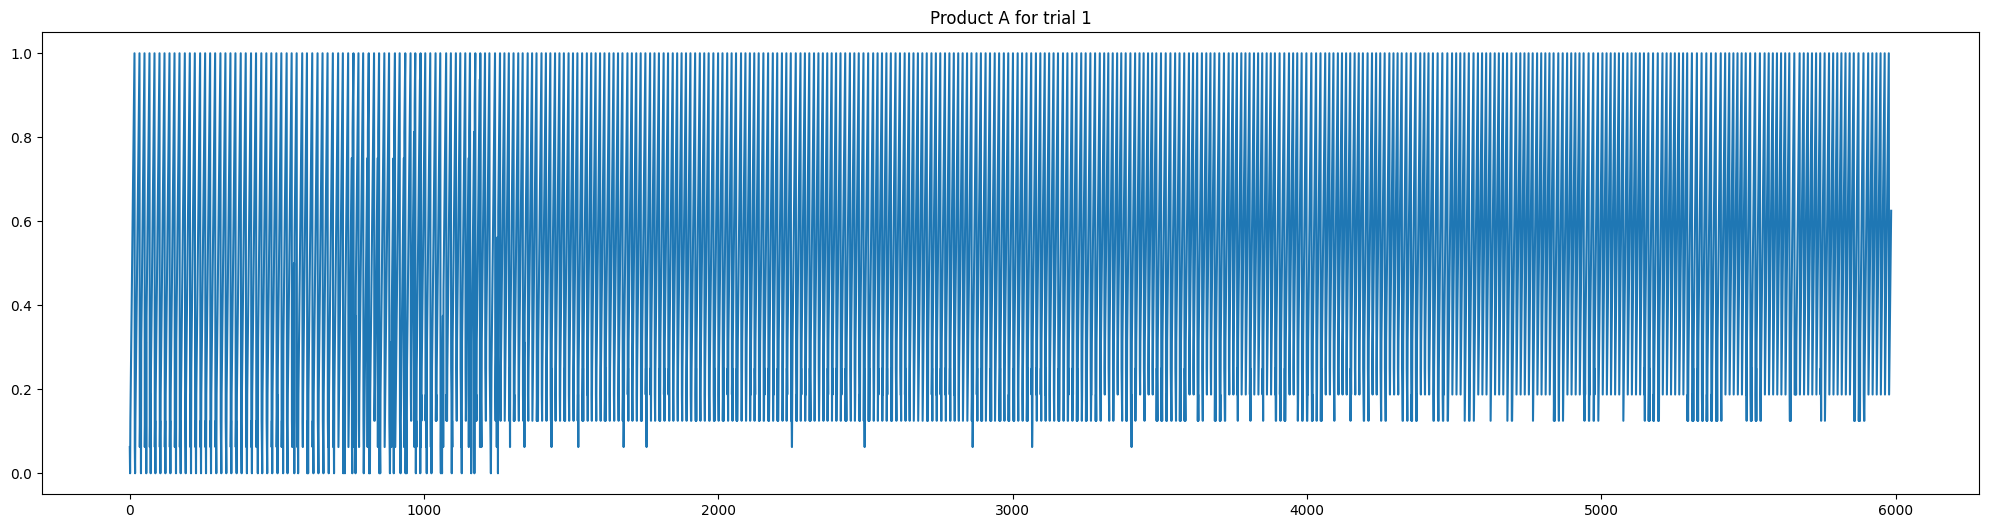

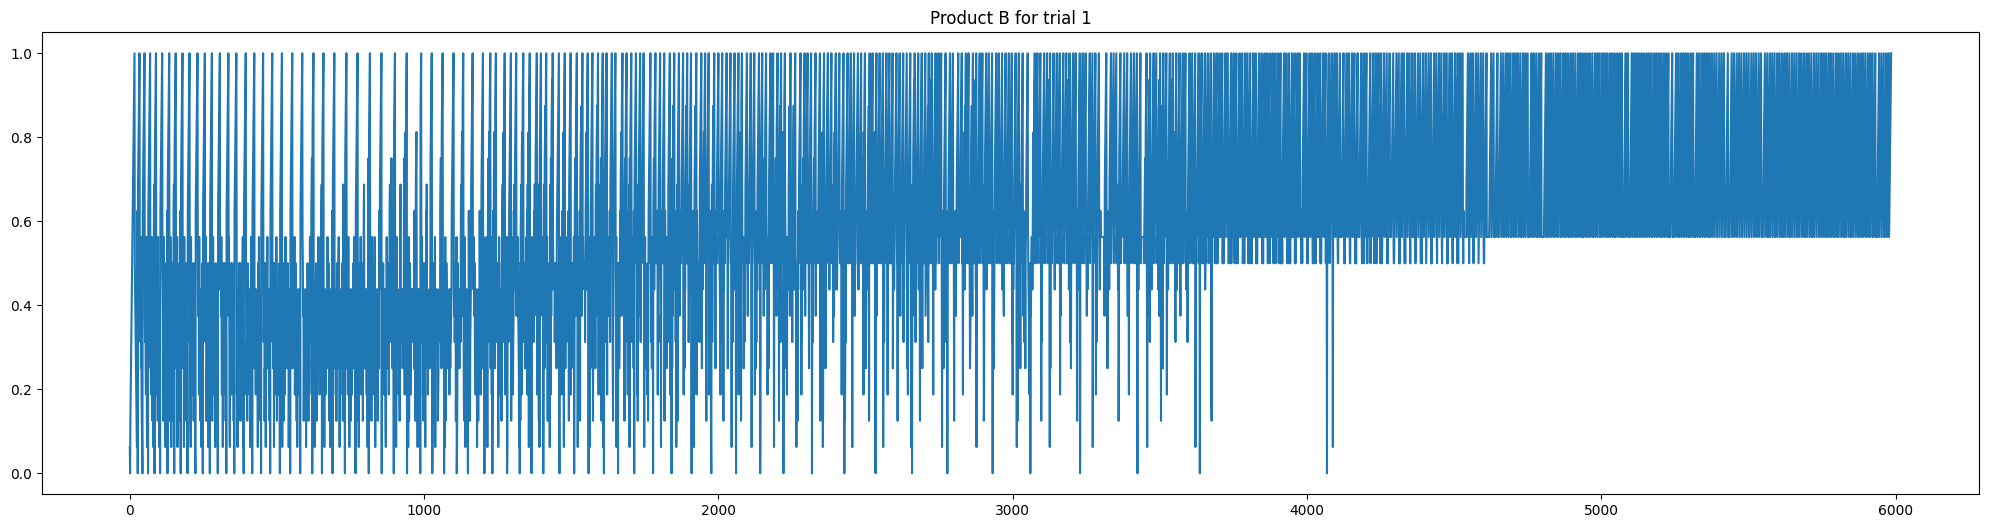

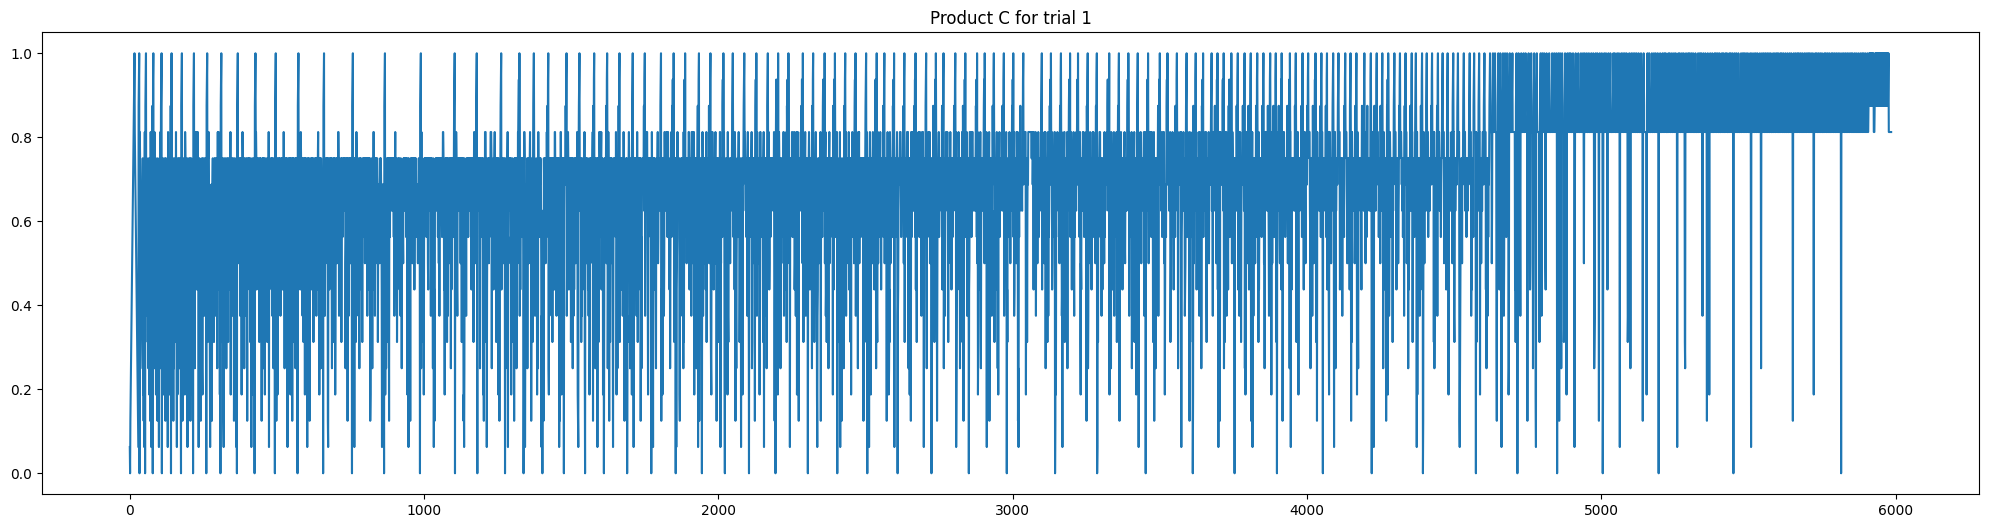

In [77]:
actions_unpacked=[[list(d.values()) for d in group] for group in actions]

for t, trial in enumerate(actions_unpacked[:2]):
    x = range(len(trial))
    for i, product in enumerate(products):
        y = [step[i] for step in trial]
        plt.figure(figsize=(25,6))
        plt.plot(x, y)
        plt.title(f'Product {product} for trial {t}')
        plt.show()


Discretizing prices with 17 values


Trial 2:   0%|          | 0/6000 [00:00<?, ?it/s]

Trial 6:   0%|          | 0/6000 [00:00<?, ?it/s]

Trial 4:   0%|          | 0/6000 [00:00<?, ?it/s]

Trial 7:   0%|          | 0/6000 [00:00<?, ?it/s]

Trial 1:   0%|          | 0/6000 [00:00<?, ?it/s]

Trial 3:   0%|          | 0/6000 [00:00<?, ?it/s]

Trial 9:   0%|          | 0/6000 [00:00<?, ?it/s]

Trial 8:   0%|          | 0/6000 [00:00<?, ?it/s]

Trial 10:   0%|          | 0/6000 [00:00<?, ?it/s]

Trial 5:   0%|          | 0/6000 [00:00<?, ?it/s]

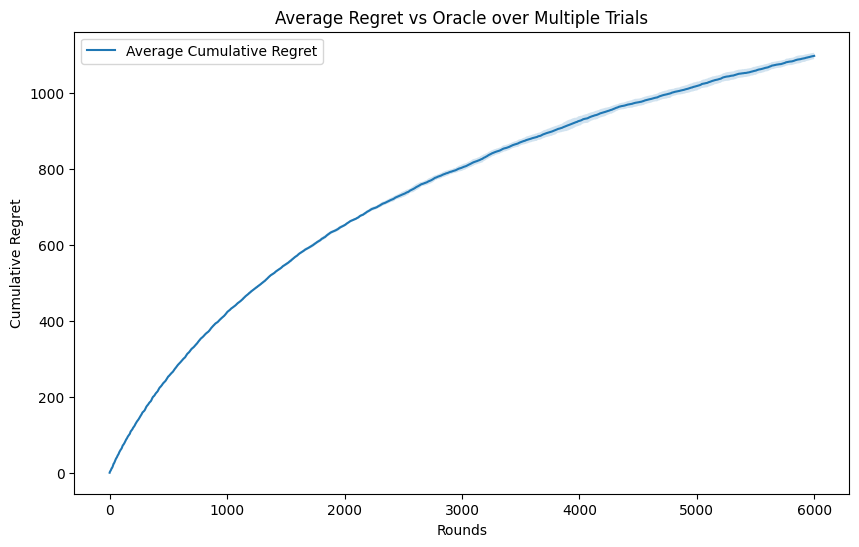

In [75]:
products = ['A','B','C']
budget = 12000
T = 6000
seeds = [23424,3431,65762,842357,2346532,13564,98765,2557,123564,123564]
epsilon = T ** (-0.33)
K = int(1 / epsilon)
print(f'Discretizing prices with {K} values')
prices_per_product = np.linspace(0, 1, K)
prices = {'A': prices_per_product, 'B': prices_per_product, 'C': prices_per_product}
means = np.array([0.1, 0.5, 0.8])
covs = 0.001*np.array([[1., 0., 0.],
                         [0., 2., 0.],
                         [0., 0., 0.5]])

# Just to plot distribution
#env = MultiProductPricingEnvironment(products=products, means=means, covs=covs, plot_distribution=True)

#run_single_trial(0, products, prices, budget, T, means, covs, seed=3)
all_regrets, actions = run_all_trials_parallel(seeds, products, prices, budget, T, means, covs, n_jobs=-1)

all_regrets = np.array([np.pad(r, (0, T-len(r)), 'edge') for r in all_regrets])
avg_regret = all_regrets.mean(axis=0)
regret_std = all_regrets.std(axis=0)

plt.figure(figsize=(10,6))
plt.plot(avg_regret, label='Average Cumulative Regret')
plt.fill_between(range(T), avg_regret-regret_std, avg_regret+regret_std, alpha=0.2)
plt.xlabel('Rounds')
plt.ylabel('Cumulative Regret')
plt.title('Average Regret vs Oracle over Multiple Trials')
plt.legend()
plt.show()

Discretizing prices with 17 values


Trial 1:   0%|          | 0/6000 [00:00<?, ?it/s]

Trial 5:   0%|          | 0/6000 [00:00<?, ?it/s]

Trial 2:   0%|          | 0/6000 [00:00<?, ?it/s]

Trial 3:   0%|          | 0/6000 [00:00<?, ?it/s]

Trial 4:   0%|          | 0/6000 [00:00<?, ?it/s]

Trial 9:   0%|          | 0/6000 [00:00<?, ?it/s]

Trial 10:   0%|          | 0/6000 [00:00<?, ?it/s]

Trial 7:   0%|          | 0/6000 [00:00<?, ?it/s]

Trial 8:   0%|          | 0/6000 [00:00<?, ?it/s]

Trial 6:   0%|          | 0/6000 [00:00<?, ?it/s]

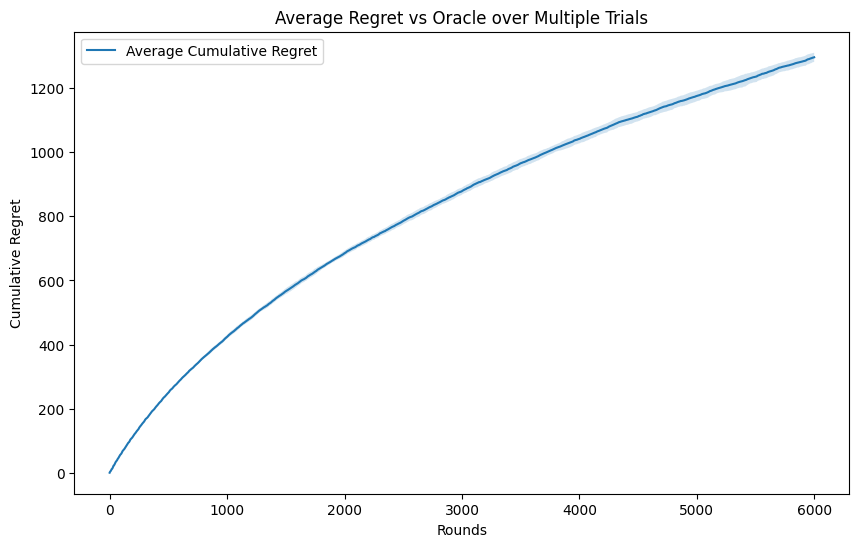

In [74]:
products = ['A','B','C']
budget = 300000
T = 6000
seeds = [23424,3431,65762,842357,2346532,13564,98765,2557,123564,123564]
epsilon = T ** (-0.33)
K = int(1 / epsilon)
print(f'Discretizing prices with {K} values')
prices_per_product = np.linspace(0, 1, K)
prices = {'A': prices_per_product, 'B': prices_per_product, 'C': prices_per_product}
means = np.array([0.1, 0.5, 0.8])
covs = 0.001*np.array([[5., 0., 0.],
                         [0., 2., 0.],
                         [0., 0., 3.]])

# Just to plot distribution
#env = MultiProductPricingEnvironment(products=products, means=means, covs=covs, plot_distribution=True)

#run_single_trial(0, products, prices, budget, T, means, covs, seed=3)
all_regrets, actions = run_all_trials_parallel(seeds, products, prices, budget, T, means, covs, n_jobs=-1)

all_regrets = np.array([np.pad(r, (0, T-len(r)), 'edge') for r in all_regrets])
avg_regret = all_regrets.mean(axis=0)
regret_std = all_regrets.std(axis=0)

plt.figure(figsize=(10,6))
plt.plot(avg_regret, label='Average Cumulative Regret')
plt.fill_between(range(T), avg_regret-regret_std, avg_regret+regret_std, alpha=0.2)
plt.xlabel('Rounds')
plt.ylabel('Cumulative Regret')
plt.title('Average Regret vs Oracle over Multiple Trials')
plt.legend()
plt.show()